In [1]:
import pandas as pd
import glob
import json
import seaborn as sns
import tarfile
import shutil

In [10]:
# decompress 'data.tar'gz'

with tarfile.open("data_finalized.tar.gz", "r:gz") as tar:
    tar.extractall()

paths = glob.glob('data/**/paths.json', recursive=True)
properties = glob.glob('data/**/properties.json', recursive=True)

df_paths = pd.DataFrame([json.load(open(file)) for file in paths])
df_properties = pd.DataFrame([json.load(open(file)) for file in properties])

# remove data folder

# shutil.rmtree('data')

In [5]:

df = pd.merge(df_paths, df_properties, on='name')

df["path_count"] = df["paths"].apply(lambda x: len(x))
df["pairablepath_count"] = df["paths"].apply(lambda x: len([y for y in x if y["pairable"]]))
df["unpairablepath_count"] = df["paths"].apply(lambda x: len([y for y in x if not y["pairable"]]))
df["min_permanent"] = df["pathsdetailed"].apply(lambda x: min([y["permanent"] for y in x]))
df["max_permanent"] = df["pathsdetailed"].apply(lambda x: max([y["permanent"] for y in x]))

In [6]:
df.query("pairable == True")

,name,nodes,edges,pairable,determinant,permanent,pathsdetailed,paths,conductance,i,j,sites,path_count,pairablepath_count,unpairablepath_count,min_permanent,max_permanent
4,junction_65918001,24,28,True,1,-1,"[{'path': [10, 21, 7, 20, 6, 17, 3, 16, 2, 13,...","[{'length': 12, 'pairable': 1, 'unpairable': 1...",0.147929,10,12,"[{'index': 0, 'x': 7.5, 'y': 0.866025403784438...",5,3,2,0.0,1.0
9,junction_74333814,8,8,True,1,1,"[{'path': [2, 5, 0, 4], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 1, 'unpairable': 1}]",1.000000,2,4,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",1,1,0,0.0,1.0
11,junction_83782337,12,13,True,1,1,"[{'path': [5, 11, 2, 10, 1, 9], 'length': 6, '...","[{'length': 6, 'pairable': 0, 'unpairable': 3}...",1.000000,5,7,"[{'index': 0, 'x': 4.5, 'y': 2.598076211353316...",2,1,1,0.0,1.0
14,junction_98671076,10,11,True,-8,9,"[{'path': [2, 6, 0, 5], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}...",0.852071,2,5,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",2,2,0,1.0,4.0
15,junction_37064223,27,32,True,0,-1,"[{'path': [28, 11, 25, 8, 24, 7, 21, 4, 20, 3,...","[{'length': 13, 'pairable': 1, 'unpairable': 1...",0.023391,12,15,"[{'index': 0, 'x': 10.5, 'y': 0.86602540378443...",7,4,3,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,junction_87425558,11,12,True,0,0,"[{'path': [13, 4, 10, 1, 9], 'length': 5, 'pai...","[{'length': 5, 'pairable': 1, 'unpairable': 1}...",0.640000,6,8,"[{'index': 0, 'x': 4.5, 'y': 0.866025403784438...",3,2,1,0.0,1.0
945,junction_95199922,10,11,True,-8,9,"[{'path': [2, 8, 1, 7], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 0, 'unpairable': 1}...",0.360000,2,7,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",3,2,1,-1.0,1.0
949,junction_81112970,20,24,True,81,-1,"[{'path': [9, 18, 6, 14, 2, 13, 1, 12], 'lengt...","[{'length': 8, 'pairable': 4, 'unpairable': 1}...",0.720897,9,12,"[{'index': 0, 'x': 4.5, 'y': 0.866025403784438...",6,4,2,-1.0,16.0
951,junction_89913158,6,6,True,-4,4,"[{'path': [7, 1], 'length': 2, 'pairable': Tru...","[{'length': 2, 'pairable': 1, 'unpairable': 0}...",0.640000,3,6,"[{'index': 0, 'x': 1.5, 'y': -0.86602540378443...",2,2,0,-1.0,1.0


<Axes: xlabel='pairablepath_count', ylabel='conductance'>

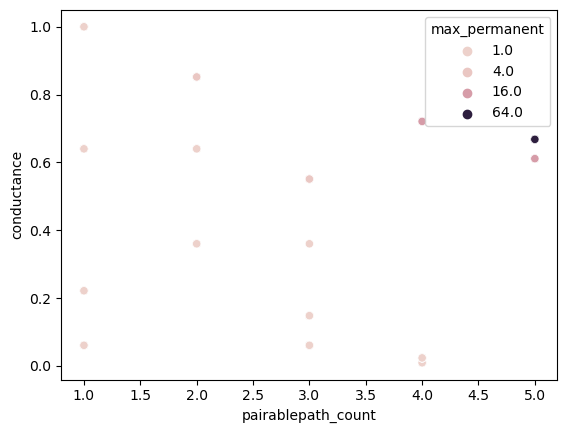

In [9]:
sns.scatterplot(
    data=df.query('pairable == True'),
    x='pairablepath_count',
    y='conductance',
    hue='max_permanent',
)

In [10]:
df

,name,nodes,edges,pairable,determinant,permanent,pathsdetailed,paths,conductance,i,j,sites,path_count,pairablepath_count,unpairablepath_count,min_permanent,max_permanent
0,junction_76582503,18,20,False,-63,-1,"[{'path': [8, 17, 6, 16, 5, 14, 3, 13, 2, 11, ...","[{'length': 11, 'pairable': 0, 'unpairable': 4...",1.562500e-22,8,9,"[{'index': 0, 'x': 7.5, 'y': 0.866025403784438...",2,0,2,0.0,0.0
1,junction_40084164,6,6,True,-4,4,"[{'path': [2, 4, 0, 3], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}]",6.400000e-01,2,3,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",1,1,0,1.0,1.0
2,junction_57512238,15,17,True,0,0,"[{'path': [7, 14, 4, 11, 1, 10, 0], 'length': ...","[{'length': 7, 'pairable': 0, 'unpairable': 3}...",3.600000e-01,7,8,"[{'index': 0, 'x': 4.5, 'y': 0.866025403784438...",4,2,2,0.0,1.0
3,junction_84079907,10,10,False,0,0,"[{'path': [3, 7, 0, 6], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 0, 'unpairable': 2}]",1.600000e-39,3,6,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",1,0,1,0.0,0.0
4,junction_55149016,14,15,False,-15,16,"[{'path': [17, 6, 15, 4, 13, 2, 12, 1], 'lengt...","[{'length': 8, 'pairable': 0, 'unpairable': 2}...",6.250000e-42,8,10,"[{'index': 0, 'x': 7.5, 'y': 0.866025403784438...",2,0,2,0.0,0.0
5,junction_70138710,20,24,False,81,-1,"[{'path': [16, 3, 15, 2, 12, 0, 11], 'length':...","[{'length': 7, 'pairable': 0, 'unpairable': 2}...",1.075446e-20,4,11,"[{'index': 0, 'x': 4.5, 'y': 0.866025403784438...",7,0,7,0.0,0.0
6,junction_21548176,8,8,False,4,4,"[{'path': [10, 3, 8, 1, 7], 'length': 5, 'pair...","[{'length': 5, 'pairable': 0, 'unpairable': 2}]",1.000000e-20,4,6,"[{'index': 0, 'x': 4.5, 'y': 0.866025403784438...",1,0,1,0.0,0.0
7,junction_37561255,6,6,True,-4,4,"[{'path': [2, 4, 0, 3], 'length': 4, 'pairable...","[{'length': 4, 'pairable': 2, 'unpairable': 0}]",6.400000e-01,2,3,"[{'index': 0, 'x': 1.5, 'y': 0.866025403784438...",1,1,0,1.0,1.0
8,junction_34728092,12,13,True,15,16,"[{'path': [5, 10, 3, 9, 2, 7, 0, 6], 'length':...","[{'length': 8, 'pairable': 4, 'unpairable': 0}]",2.214533e-01,5,6,"[{'index': 0, 'x': 4.5, 'y': 0.866025403784438...",1,1,0,1.0,1.0
